# Normalising the power spectrum

In [11]:
import numpy as np
from numpy import (fft, random)
from scipy.integrate import (quad)
from matplotlib import pyplot as plt
from cosmology import Cosmology, Planck2018, norm_integrant, W_th

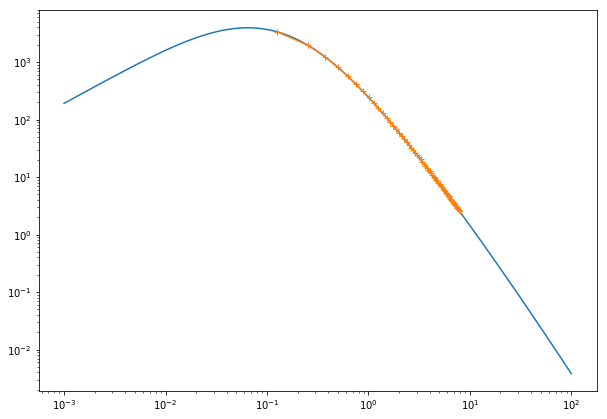

In [58]:
cosmology = Planck2018

N = cosmology.N
k = np.logspace(-3, 2, 100)
kx = cosmology.freq[1:N//2]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.loglog(k, cosmology.P(k))
ax.loglog(kx, cosmology.P(kx), marker='+')
plt.show()

# Accuracy of the integral method

Usually normalisation is presented as computing the integral
$$\sigma_R = \int_{-\infty}^{\infty} P(k) W_{\rm th}^2(Rk) k^2 \frac{{\rm d} k}{2 \pi^2}.$$
This doesn't always give the best results though. An alternative is to integrate from a lower bound of $2\pi/L$. The following compares this method with summing over all $k$ in the box.

In [13]:
s = []
for i in np.arange(2, 8):
    N = 2**i
    for L in random.uniform(10.0, 500.0, 10):
        cosmology.L = L
        cosmology.N = N

        k = cosmology.k_abs.flat[1:]
        cosmology.A = 1.0
        cosmology.A = cosmology.sigma8**2 / quad(norm_integrant(cosmology.P, 8.0),
                  (2*np.pi)/cosmology.L,
                  np.inf)[0]

        s.append([N, L, np.sqrt(1. / cosmology.V * np.sum(cosmology.P(k) * W_th(8.0 * k)**2))])
s = np.array(s)

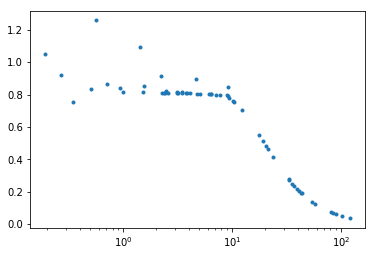

In [14]:
plt.semilogx(s[:,1] / s[:,0], s[:,2], '.')

# Look at the shape of W_th

In [32]:
N = cosmology.N
L = cosmology.L = 50.0
with np.errstate(divide='ignore', invalid='ignore'):
    w = W_th(15 * cosmology.k_abs)

In [33]:
w[0,0,0] = 1.0

In [34]:
f = np.zeros(shape=cosmology.shape)
# f = random.normal(size=cosmology.shape)
f[N//2,N//2,N//2] = 1.0
g = fft.ifftn(fft.fftn(f) * w).real

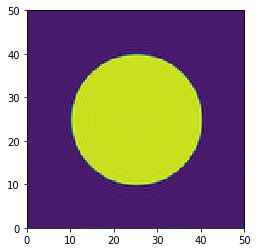

In [35]:
plt.imshow(g[N//2], extent=[0, L, 0, L])

# Measuring the Power spectrum of a field

In [37]:
N = cosmology.N
L = cosmology.L
k = cosmology.k_abs
i = np.argsort(k.flatten())

f = random.normal(0.0, 1.0, size=cosmology.shape)
d = fft.ifftn(fft.fftn(f) * np.sqrt(cosmology.P(k) * (N / L)**3)).real

In [38]:
F = fft.fftn(d) / N**(3/2)
P = (F * F.conj()).real * (L / N)**3
P[0,0,0] = 0
y = P.flat[i].reshape(N, -1).std(axis=1)
x = k.flat[i].reshape(N, -1).mean(axis=1)

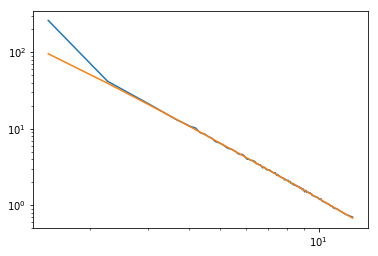

In [39]:
plt.loglog(x, y)
plt.loglog(x, cosmology.P(x))

# Measure $\sigma_8$

In [40]:
d.std()

8.936939660829506

In [42]:
with np.errstate(divide='ignore', invalid='ignore'):
    w = W_th(8.0 * cosmology.k_abs) ; w[0,0,0] = 1.0
g = fft.ifftn(fft.fftn(d) * w).real

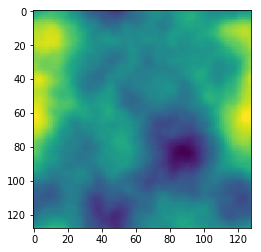

In [43]:
plt.imshow(g[N//2])

In [44]:
g.std()

0.7478154717170816

In [45]:
s = []
cosmology.N = 64
for res in np.logspace(-2, 1, 21):
    cosmology.L = cosmology.N * res
    cosmology.normalise()
    N = cosmology.N
    L = cosmology.L
    k = cosmology.k_abs
    # i = np.argsort(k.flatten())

    q = []
    for j in range(10):
        f = random.normal(0.0, 1.0, size=cosmology.shape)
        w = W_th(8.0 * cosmology.k_abs) ; w[0,0,0] = 1.0
        d = fft.ifftn(fft.fftn(f) * np.sqrt(cosmology.P(k) * (N/L)**3) * w).real
        q.append(d.std())
    
    s.append(q)
s = np.array(s)

/mnt/Knolselderij/johannes/Thesis/cosmo-cgal-demo/notebooks/cosmology.py:24: RuntimeWarning: divide by zero encountered in true_divide
  return 3 / y**3 * (np.sin(y) - y * np.cos(y))
/mnt/Knolselderij/johannes/Thesis/cosmo-cgal-demo/notebooks/cosmology.py:24: RuntimeWarning: invalid value encountered in multiply
  return 3 / y**3 * (np.sin(y) - y * np.cos(y))


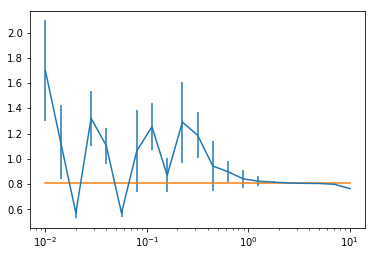

In [46]:
fig, ax = plt.subplots(1, 1)
ax.set_xscale("log", nonposx='clip')
# ax.set_yscale("log", nonposy='clip')
x = np.logspace(-2, 1, 21)
ax.errorbar(x, s.mean(axis=1), yerr=s.std(axis=1))
ax.plot(x, 0.811 * np.ones_like(x))

In [47]:
import h5py as h5

In [54]:
file = h5.File('../output/lcdm.h5')

In [55]:
p = file["potential"][:]
N = 128
L = 50.0
cosmology.N = N
cosmology.L = L
cosmology.normalise()
k = cosmology.k_abs
i = np.argsort(k.flat)

In [56]:
F = fft.fftn(p) / N**(3/2) * k**2
P = (F * F.conj()).real * (L / N)**3
# P[0,0,0] = 0
y = P.flat[i].reshape(N, -1).std(axis=1)
x = k.flat[i].reshape(N, -1).mean(axis=1)

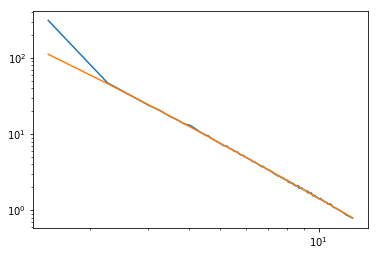

In [57]:
plt.loglog(x, y)
plt.loglog(x, cosmology.P(x))

In [52]:
file.close()